In [0]:
%matplotlib inline
import warnings;
warnings.filterwarnings('ignore');
import matplotlib.pyplot as plt;
import numpy as np;
import pandas as pd;
import seaborn as sns;
sns.set_context("notebook", font_scale=1.4);
sns.set_style("whitegrid");

In [0]:
###util methods
from matplotlib.colors import ListedColormap
def plot_decision_boundary(clf,X,y):
  cols = X.columns.values
  X = X.values
  y = y.values
  cm = plt.cm.brg	
  cm_bright = ListedColormap([ '#0000FF','#00FF00'])
  x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
  y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
  xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.2),
  					 np.arange(y_min, y_max, 0.2))
  Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
  Z = Z.reshape(xx.shape)
  plt.figure(figsize=(12,12))
  plt.contourf(xx, yy, Z, cmap=cm, alpha=.5)
  plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
  plt.title("accuracy=%.2f"%(clf.score(X,y)))
  plt.xlabel(cols[0])
  plt.ylabel(cols[1])
def plot_lr_cost():
	a = np.arange(-6, 6, .001)
	plt.figure(figsize=(8,4))
	plt.plot(a,-1*np.log(1/(1+(np.exp(-1*a)))),linewidth=3.0,label="y=1")
	plt.plot(a,-1*np.log(1-(1/(1+(np.exp(-1*a))))),linewidth=3.0,label="y=0")
	plt.xlabel(r"$f(x,\theta)$", fontsize=22)
	plt.ylabel(r"$cost(f(x,\theta))$", fontsize=20)
	plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
def plot_logistic(theta):
	f = lambda x, theta: 1. / (1. + np.exp(-x.dot(theta)))
	#create a dataset with m=2
	x = np.c_[np.ones(100), np.linspace(-10,20,100)] #x0 is set 1
	#compute f(x,theta)
	y = f(x, theta)
	plt.xlabel(r"$\theta^{\prime} x$", fontsize=20)
	plt.ylabel(r"$lr(x,\theta)$", fontsize=20)
	plt.plot(x.dot(theta), y)

# 3. Logistic regression

**Logistic regression** (or **logit regression**) is a classification learning algorithm where the target (or **label** in this case) is **a class**. This is somewhat confusing as the term 'regression' is normally used for modeling a continuous target as with linear regression. However as logistic regression is derived from linear regression (as we will see) the term logistic regression is still accepted.

The logistic regression algorithm only works for **two class** data sets ($y \in \{0,1\})$ and assumes the data is **linearly separable**. Logistic regression is a popular algorithm in bioinformatics as it can learn accurate predictive models for large data sets very fast. 

As we will see logistic regression models predict **class probabilities** rather than classes. These probabilities can be seen as an estimation of the confidence the model has in a prediction. 

Let's open a data set:

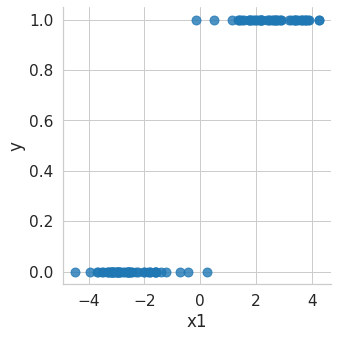

In [26]:
dataset = pd.read_csv("https://raw.githubusercontent.com/sdgroeve/Machine_Learning_course_UGent_D012554/master/notebooks/3_logistic_regression/logistic.csv")

sns.lmplot(x="x1", y="y", data=dataset, fit_reg=False, height=5, scatter_kws={"s": 80})
plt.show()

Here $y$ is the label and can be one of two classes: 0 and 1. Just as with linear regression we will try to model the releationship between the feature $x_1$ and $y$.

So how does classification differ from regression? After all we could just try to fit a linear model

$$f(x,\theta) = \theta^{\prime} x=\theta_0x_0 + \theta_1x_1$$

to the data. This would compute a linear function $f(x,\theta)$ that shows the linear relation between $x_1$ and $y$.

We can then apply a **threshold** to map the output of $f(x,\theta)$ onto class 0 or 1. For instance $y=1$ if $f(x) \geq 0.5$ and $y=0$ otherwise:

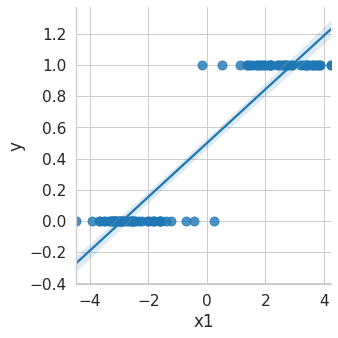

In [27]:
from sklearn import metrics

sns.lmplot(x="x1", y="y", data=dataset, fit_reg=True, height=5, scatter_kws={"s": 80})
plt.show()

This linear fit achieves $R^2=0.88$, which would seem good. Although judging from the plot we have to admit it doesn't look right. 

We can obtain a much better fit by using the non-linear **logistic function** $g(z)$ instead of the linear function to better model our data. 

This model is formalized as

$$ f(x,\theta)=g(\theta^{\prime} x),$$

with

$$g(z)=\frac{1}{1+e^{-z}}.$$

The following plot shows how $f(x,\theta)$ non-linearly transforms $\theta^{\prime} x$ into a value between zero and one (which are the class probabilities):

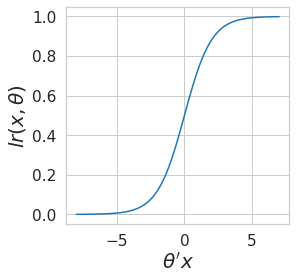

In [28]:
plt.figure(figsize=(4,4))
plot_logistic([2, -0.5])
plt.show()

Since we assume the data to be **linearly separable instead to linearly related** we have to also adapt the cost function $J(\theta)$ accordingly. The cost for the logistic regression learning algorithm is 

$$J(\theta)=-[\frac{1}{n}\sum\limits_{i=1}^ny^{(i)}log(f(x^{(i)},\theta))+(1-y^{(i)})log(1- f(x^{(i)},\theta))].$$

Let's take a closer look at this cost function. 

We know that $y^{(i)}$ is either 0 or 1. If $y^{(i)}=1$ then the cost function $J(\theta)$ is incremented by

$$-log(f(x^{(i)},\theta)).$$

Similarly, if $y^{(i)}=0$ then the cost function $J(\theta)$ is incremented by

$$-log(1- f(x^{(i)},\theta)).$$

To understand this we can plot these increments as a function of $f(x,\theta)$:

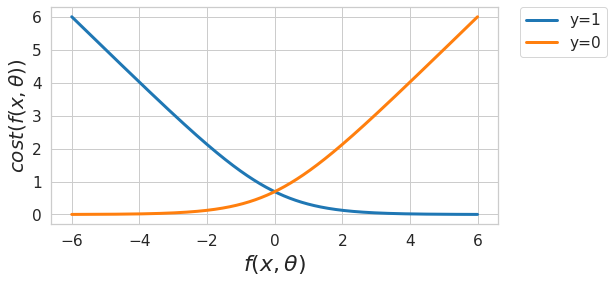

In [29]:
plot_lr_cost()
plt.show()

The blue curve shows the increment to the cost function for $y=1$. In this case if $f(x,\theta)$ is large then the increment should be small. If instead $f(x,\theta)$ is small then the increment should be large. We can see that the increment shown in the blue curve does indeed satisfy these criteria. The green curve shows the increment for $y=0$. In this case if $f(x,\theta)$ is small then the increment should be small. If instead $f(x,\theta)$ is large then the increment should be large. 

We use the gradient descent optimization algorithm to find the optimal values for $\theta$ given a train set. Similarly to linear regression the increments or decrements in each iteration are computed as:

$$\theta_0:=\theta_0-\alpha\frac{1}{n}\sum\limits_{i=1}^n(f(x^{(i)},\theta)-y^{(i)})x_0^{(i)},$$

$$\theta_1:=\theta_1-\alpha\frac{1}{n}\sum\limits_{i=1}^n(f(x^{(i)},\theta)-y^{(i)})x_1^{(i)},$$

with $\alpha$ again the learning rate that controls the convergence of the gradient descent iterations. 

In scikit-learn we can use the module `LogisticRegression` to compute the optimal logistic function for our data to obtain a much better fit of the data:

In [30]:
from sklearn.linear_model import LogisticRegression
 
model = LogisticRegression(C=10000)
model.fit(dataset[['x1']],dataset['y'])

predictions = model.predict_proba(dataset[['x1']])[:,1]

print("R-squared = {}".format(metrics.r2_score(dataset['y'],predictions)))

R-squared = 0.9612641591406965


Now  $R^2=0.96$. When we plot this logistic function we can see why the fit is much better:

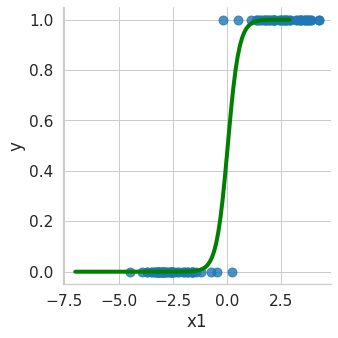

In [31]:
def logistic(theta0,theta1,x):
    return 1/(1+(np.exp(-1*(theta0+(x*theta1)))))

sns.lmplot(x="x1", y="y", data=dataset, fit_reg=False, height=5, scatter_kws={"s": 80})
plt.plot(np.arange(-7,3,0.1),logistic(model.intercept_,model.coef_[0],np.arange(-7,3,0.1)),lw=4,color='green')
plt.show()

In fact, the function value $y$ of the logistic fit will always be a value between 0 and 1 and estimates the probability of a data point belonging to class 1. Again we can apply a threshold to map the output of $f(x,\theta)$ onto a class.

When we have $m$ dependent variables in our data set the cost function for logistic regression becomes

$$f(x,\theta)=g(\theta_0x_0 + \theta_1x_1 + \theta_2x_2+...+\theta_mx_m) = g(\theta^{\prime} x),$$

and the updates during gradient descent are computed as

$$\theta_j:=\theta_j-\alpha\frac{1}{n}\sum\limits_{i=1}^n(f(x^{(i)},\theta)-y^{(i)})x_j^{(i)}.$$

Let's take a look at an example for $m=2$. We load a data set with two features and apply logistic regression to compute a probabilistic decision boundary:

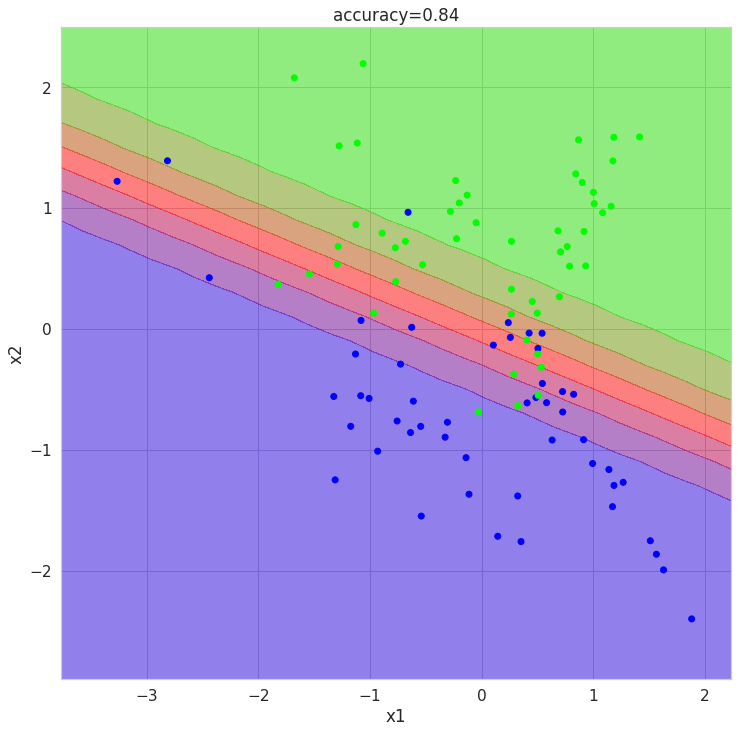

In [34]:
dataset2D = pd.read_csv("https://raw.githubusercontent.com/sdgroeve/Machine_Learning_course_UGent_D012554/master/notebooks/3_logistic_regression/dataset2D.csv")

X = dataset2D.copy()
y = X.pop('y')

model = LogisticRegression(C=100000)
model.fit(X,y)
score = model.score(X, y)

plot_decision_boundary(model,X,y)
plt.show()

The green data points have $y=0$ and the blue points have $y=1$. This scatter plot suggests the following rule for classifying the feature vectors (lesions): 
New feature vectors are classified with high confidence as class 1 if they are located in the green zone; classified with high confidence as class 0 if they are in the blue zone; and classified with lower confidence (depending on whether it is more green or more blue).

In scikit-learn the module `LogisticRegression` contains a method `predict_proba()` that predicts the probabilities for the classes in a data set given a trained model:

In [33]:
predictions = model.predict_proba(X)
print(predictions[:10])

[[0.00553228 0.99446772]
 [0.99134154 0.00865846]
 [0.67604606 0.32395394]
 [0.03951735 0.96048265]
 [0.91256065 0.08743935]
 [0.55022592 0.44977408]
 [0.65700975 0.34299025]
 [0.00670764 0.99329236]
 [0.06457313 0.93542687]
 [0.02768094 0.97231906]]


**Multiclass** or **multinomial** classification is the problem of classifying data points into one of more than two classes. Logistic regression computes **binary** classification models that can only separate two classes. Most machine learning classification learning algorithms compute binary classification models, but there exist also learning algorithms that can compute multiclass models.

Here we describe two popular methods that combine binary classifiers to produce a multiclass classifier: **one-against-all** and **one-against-one**.

Suppose we have a data set with $H$ classes. The one-against-all (or one-against-rest) method involves training a single classifier for each class $h_i$, with the data points that belong to class $h_i$ labeled as positive and all other data points labeled as negative. 

This method requires the binary classifier to compute a real-valued confidence score for its decision, rather than just a class label. Discrete class labels alone can lead to ambiguities, where multiple classes are predicted for a single sample. 

When a test point is presented each binary classifier is applied and the class $h_i$ associated with the classifier that computes the highest confidence is the predicted class for the test point. 

The one-against-one method involves training

$$\frac{H(H-1)}{2}$$

binary classifiers where each model is trained on the data points that belong to a pair of classes from the original train set, and must learn to distinguish these two classes. 

When a test point is presented each of these binary classifiers is applied and the class that got the highest number of positive predictions (potentially taking confidence into account) gets predicted by the combined classifier.